# Overview

This notebook provides a high-level overview of what we are trying to achieve.

## Workflow Goals

1. Determine surface elevation, $E(i,j)$, at resoultion $R$ ($R$ is 10cm for now).

1. Normalize $P(x,y,z)$ values to local elevation: $P(x,y,z^{\prime}) = P(x,y,z) - E(i,j)$

-----

Additional/Prior Goals:

1. Cluster $P(r,g,b)$ data into $N$ categories. Goal is to isolate "soil/stem" and "canopy" elements, as well as shadowed areas.

1. Determine point density and cluster membership density for each voxel.


In [26]:
%matplotlib inline
from scipy.spatial import KDTree
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Pointcloud analysis Functions

- `adjust_to_ground`
- `adjust_to_origin`
- `elev_cut`
- `get_density`


### Find the gound surface in an X,Y,Z  point cloud

In [36]:
def adjust_to_ground(points, resolution=0.1, method='linear'):
    """ Makes an interpolated surface and re-normalizes 
        vertical elevations based on local ground elevation.
    
    Usage: adjusted_points = adjust_to_ground(points, resolution, method)
    
        points: pandas dataframe containing point cloud with X, Y, Z coordinates.
        resolution: resolution of ground interpolation in meters [default=0.1 m]
        method: method for interpolation [default = linear]
        
    Notes: 
        
        - Interpolation uses `scipy.interpolate.griddata`
        - Absolute minimum observed elevation in every cell is assumed to be ground.
        
    """
    
    points['Xidx'] = (points.X/resolution).astype(int)
    points['Yidx'] = (points.Y/resolution).astype(int)
    
    ground = points.groupby(['Xidx','Yidx']).min()
    ground = ground.reset_index()

    # Drop the original X and Y axes, and reassign.
    ground.drop(['X','Y'], axis=1, inplace=True)
    ground.columns = ['X', 'Y', 'z_min']
    return ground



### Renormalize X and Y locations to 0,0 origin

In [28]:
def adjust_to_origin(points):
    """ Renormalizes the X and Y coordinates to a 0,0 origin 
    
    
    Usage: points = adjust_to_origin(points)
    
        points: pandas dataframe containing point cloud with X, Y, Z coordinates
    
    """
    points.X = points.X - points.X.min()
    points.Y = points.Y - points.Y.min()
    
    return points

### Threshold data above  $z_{min}$

In [30]:
def elev_cut(points, z_min=0.2):
    """ Returns only points above a value of z_min (meters). 
    
    Usage: points = elev_cut(points, z_min)
    
        points: pandas dataframe containing point cloud with X, Y, Z coordinates
        elev_cut: z_min of elevation to keep in data (meters, default=0.2)
        
    """
    return points.loc[(points['Z'] > z_min)]

### Get the total density of points, $P(x,y,z)$ in every subsampled region, $E(i,j)$.


In [31]:
def get_density(points, resolution=0.1):
    """ Resamples an X,Y,Z pointcloud at a specific resolution and 
    returns a dataframe of total density in each resampled cell.
    
    Usage: density = get_density(points, resolution)
    
        points: pandas dataframe containing point cloud with X,Y,Z coordinates
        resolution: size of resampling cell (meters) in X and Y dimensions (default = 0.1 meters)
    
    """
    points['Xidx'] = (points.X/resolution).astype(int)
    points['Yidx'] = (points.Y/resolution).astype(int)
    
    density = points.groupby(['Xidx','Yidx']).count()
    density = density.reset_index()

    # Drop the original X and Y axes, and reassign.
    density.drop(['X', 'Y'], axis=1, inplace=True)
    density.columns = ['X', 'Y', 'total']
    return density

### Plot a point cloud at a specific resolution

# Process an example pointcloud

## Load a sample point cloud for example purposes 

In [33]:
filename = 'uhnb1_con_b_c_xyz.csv'
points = pd.read_csv(filename)

### Step 1. Adjust to origin

In [34]:
points = adjust_to_origin(points)

### Step 2. Find ground elevation

In [37]:
points = adjust_to_ground(points)

### Plot the ground elevation for each subsampled region, $E(i,j)$

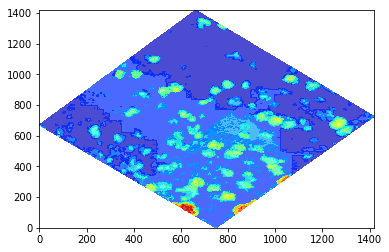

In [10]:
groundpivot=ground.pivot('X', 'Y')

X=groundpivot.columns.levels[1].values
Y=groundpivot.index.values
Z=groundpivot.values

Xi,Yi = np.meshgrid(X, Y)
plt.contourf(Yi, Xi, Z, alpha=0.7, cmap=plt.cm.jet);

## Use an arbitrary interpolation

/Users/kellycaylor/anaconda3/envs/sfm/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/Users/kellycaylor/anaconda3/envs/sfm/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/Users/kellycaylor/anaconda3/envs/sfm/lib/python3.6/site-packages/matplotlib/colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


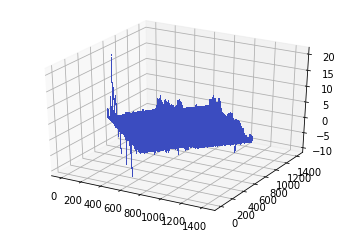

In [19]:
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
from matplotlib import cm

x1 = np.linspace(ground['X'].min(), ground['X'].max(), len(ground['X'].unique()))
y1 = np.linspace(ground['Y'].min(), ground['Y'].max(), len(ground['Y'].unique()))


#"""
#x, y via meshgrid for vectorized evaluation of
#2 scalar/vector fields over 2-D grids, given
#one-dimensional coordinate arrays x1, x2,..., xn.
#"""

x2, y2 = np.meshgrid(x1, y1)

# Interpolate unstructured D-dimensional data.
z2 = griddata((ground['X'], ground['Y']), ground['z_min'], (x2, y2), method='cubic')

# Ready to plot
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(
    x2, y2, z2, rstride=1, cstride=1, cmap=cm.coolwarm,
    linewidth=0, antialiased=False
)
